In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Foreword

MNIST database is a large dataset of handwritten digits used predominantly for training image processing algorithms and for learning. The database contains over 60,000 training images and 10,000 testing images which are monochrome images normalized and anti-aliased to fit a 28x28 pixel bounding box. The [original paper used SVM](https://ieeexplore.ieee.org/document/726791) and saw an error rate of 0.8%.

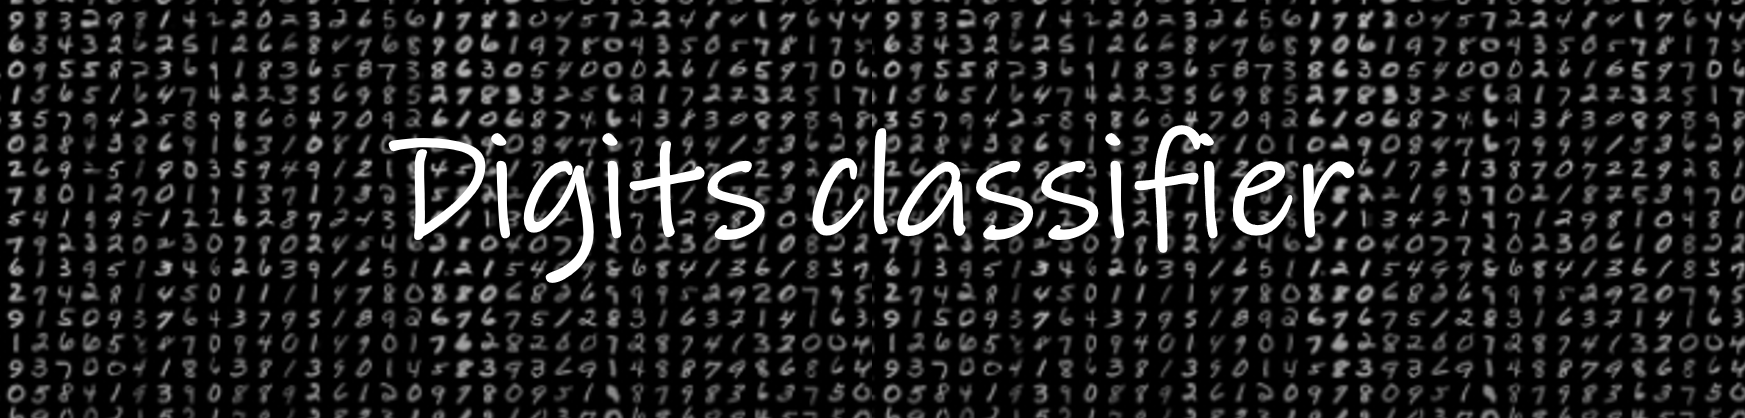



# The data

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_dat = pd.read_csv('../input/digit-recognizer/train.csv')
test_dat = pd.read_csv('../input/digit-recognizer/test.csv')

In [4]:
print(train_dat.info())
print(test_dat.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None


<AxesSubplot:xlabel='label', ylabel='count'>

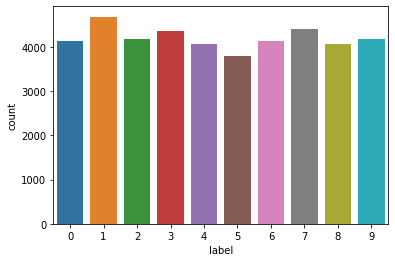

In [5]:
sns.countplot(train_dat['label'])

In [6]:
x_train = train_dat.iloc[:,1:].to_numpy(copy=True).reshape((train_dat.shape[0],28,28))
y_train = train_dat.iloc[:,0].to_numpy(copy=True)
x_test = test_dat.iloc[:,:].to_numpy(copy=True).reshape((test_dat.shape[0],28,28))
print(x_train.shape, y_train.shape, x_test.shape)

(42000, 28, 28) (42000,) (28000, 28, 28)


In [7]:
def sample_and_plot(dat, df, titl, flag):
    import random
    random.seed(0)
    n= 100
    samples = random.sample(range(dat.shape[0]),n)

    fig, axs = plt.subplots(10,10,figsize=(20,20),sharex=True,sharey=True)
#     fig.suptitle(titl)
    for i, isample in enumerate(samples):
        r,c = divmod(i,10)
        axs[r,c].imshow(dat[isample,:,:])
        if flag:
            axs[r,c].set_title(df.iloc[isample,0])
        axs[r,c].set_xticks([])
        axs[r,c].set_yticks([])

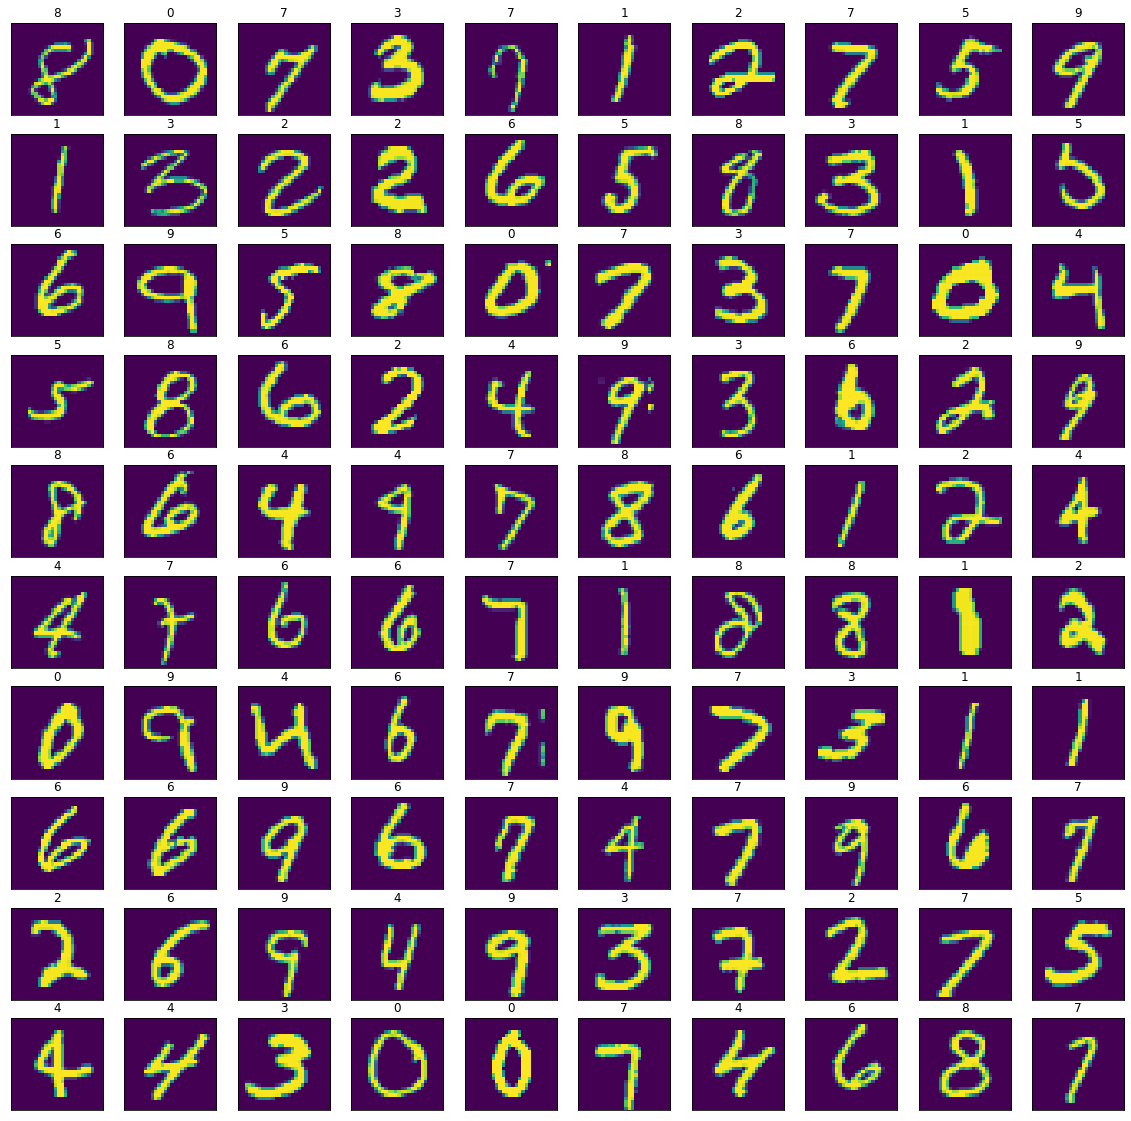

In [8]:
sample_and_plot(x_train, train_dat, 'Samples from Training set', True)    

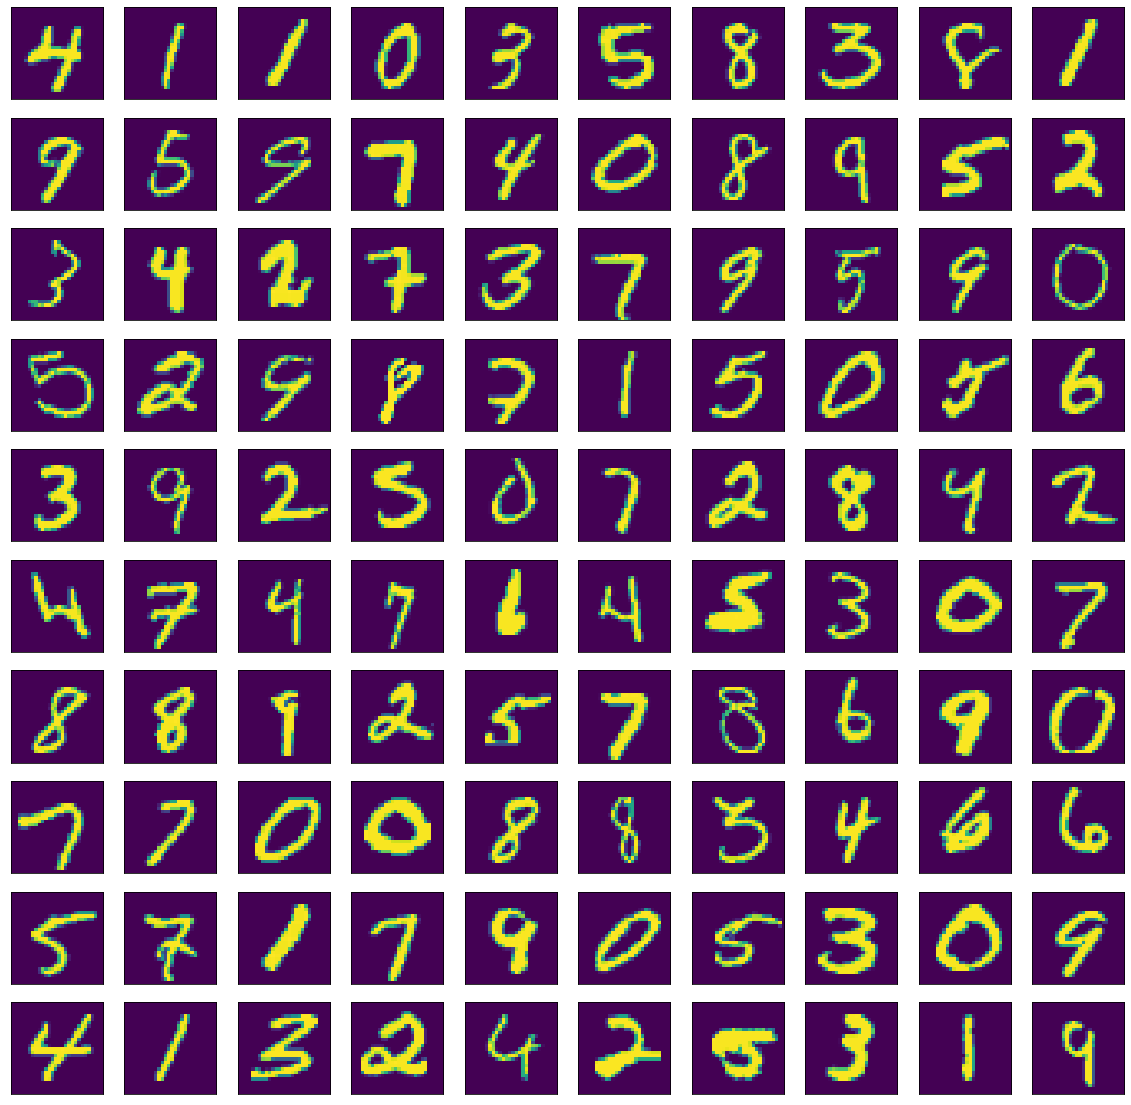

In [9]:
sample_and_plot(x_test, test_dat, 'Samples from test set', False)

# Using SVM

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

In [11]:
X = train_dat.copy()
y = X['label'].copy()
X.drop(columns=['label'], inplace=True)
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(X, y, test_size=0.2, random_state=1)
print(Xtrain.shape, Xvalid.shape, Ytrain.shape, Yvalid.shape)

(33600, 784) (8400, 784) (33600,) (8400,)


In [12]:
sv = SVC(random_state=1, kernel='rbf',verbose=True)
sv.fit(Xtrain, Ytrain)
Ypredict = sv.predict(Xvalid)
print('Confusion Matrix:\n',confusion_matrix(y_true=Yvalid, y_pred=Ypredict))
print('Accuracy:\n',accuracy_score(y_true=Yvalid, y_pred=Ypredict))

[LibSVM]Confusion Matrix:
 [[847   0   0   0   1   2   3   0   0   0]
 [  0 934   1   3   0   0   0   0   2   0]
 [  1   1 817   1   2   0   2   5   5   1]
 [  1   0   8 841   0  11   0   4   5   3]
 [  0   1   2   0 813   0   1   4   0   8]
 [  2   1   0  10   0 712   3   0   1   2]
 [  3   0   1   0   4   3 789   0   0   0]
 [  0   3   4   0   3   0   0 830   0  10]
 [  1   5   0   2   4   5   3   1 822   3]
 [  4   1   1   3  11   2   0   8   2 811]]
Accuracy:
 0.9780952380952381


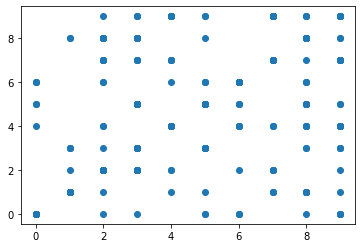

In [13]:
plt.scatter(Yvalid.to_numpy(),Ypredict)

**Hyper-Parameter tuning**

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
# hyper_par = [{'gamma':[1e-2,1e-4], 'C':[1,5]}]
# mod = SVC(random_state=1, kernel = 'rbf', verbose=True)

# mod_cv = GridSearchCV(estimator=mod, param_grid=hyper_par, verbose=4, scoring='accuracy')
# mod_cv.fit(Xtrain, Ytrain)

# takes too long ... 

**Prediction**

In [16]:
Ytestpredict = sv.predict(test_dat)

In [22]:
submission = pd.DataFrame({'ImageID':test_dat.index+1, 'Label':Ytestpredict})
submission.to_csv('my_submission.csv',index=False)

In [23]:
submission.head()

,ImageID,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
